In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:

# define a transforms for preparing the dataset
transform = transforms.Compose([

transforms.CenterCrop(26),
# transforms.Resize((150,150)),
# transforms.Resize((250, 250)),
transforms.Pad(80),
transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
transforms.Grayscale(1),
transforms.RandomRotation(10),      
transforms.RandomAffine(5),
transforms.RandomPerspective(distortion_scale=0.65, p=0.8),
transforms.ElasticTransform(),
transforms.GaussianBlur(kernel_size=(3,3)),
transforms.Resize((200,200)),

# convert the image to a pytorch tensor
transforms.ToTensor(), 

# normalise the images with mean and std of the dataset
transforms.Normalize((0.1307,), (0.3081,)) 
])

# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` 
# using the transform defined above

train_dataset = datasets.MNIST('./data_padding',train=True,transform=transform,download=True)
test_dataset =  datasets.MNIST('./data_padding',train=False,transform=transform,download=True)

# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set

train_dataloader = Data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=True) 
                

(torch.Size([128, 1, 200, 200]),
 torch.float32,
 tensor(5),
 torch.Size([1, 200, 200]),
 <matplotlib.image.AxesImage at 0x7c21b025c670>)

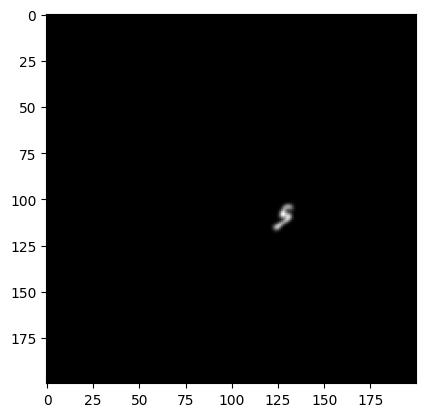

In [42]:
a= next(iter(train_dataloader))
b = a[0][0].detach().clone()
a[0].shape, a[0].dtype, a[1][0], b.shape, plt.imshow(b.permute(1,2,0), cmap='gray')

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #! 210 input
        # define a conv layer with output channels as 16
        self.conv11 = nn.Conv2d(1, 16, 6, 2) 
        self.conv12 = nn.Conv2d(1, 16, 10, 2)
        self.conv13 = nn.Conv2d(1, 16, 14, 2) 
        self.conv14 = nn.Conv2d(1, 16, 18, 2) 

        # define a conv layer with output channels as 32
        self.conv21 = nn.Conv2d(16, 32, 3, 2)
        self.conv22 = nn.Conv2d(16, 32, 5, 2)
        self.conv23 = nn.Conv2d(16, 32, 7, 2) 
        self.conv24 = nn.Conv2d(16, 32, 9, 2) 

        # define a conv layer with output channels as 64
        self.conv31 = nn.Conv2d(32, 64, 3, 2) 
        self.conv32 = nn.Conv2d(32, 64, 5, 2) 
        self.conv33 = nn.Conv2d(32, 64, 7, 2)
        self.conv34 = nn.Conv2d(32, 64, 9, 2)

        self.conv41 = nn.Conv2d(64, 128, 3, 1)
        self.conv42 = nn.Conv2d(64, 128, 5, 1)
        self.conv43 = nn.Conv2d(64, 128, 7, 1) 
        self.conv44 = nn.Conv2d(64, 128, 9, 1) 




        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(2) 
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.5)

        # define a linear(dense) layer with 128 output features
        self.fc11 = nn.Linear(128*10*10, 256)
        self.fc12 = nn.Linear(128*8*8, 256)
        self.fc13 = nn.Linear(128*6*6, 256)
        self.fc14 = nn.Linear(128*4*4, 256)

        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc21 = nn.Linear(256, 128)
        self.fc22 = nn.Linear(256, 128)
        self.fc23 = nn.Linear(256, 128)
        self.fc24 = nn.Linear(256, 128)

        self.fc33 = nn.Linear(128*4,10)


    def forward(self, inp):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 conv4 and fc1 use a relu activation. 

        x = F.relu(self.conv11(inp))
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv31(x))
        x = F.relu(self.maxpool(self.conv41(x)))

        x = x.view(-1,128*10*10)
        x = self.dropout1(x)
        x = F.relu(self.fc11(x))
        x = self.dropout2(x)
        x = self.fc21(x)

        y = F.relu(self.conv12(inp))
        y = F.relu(self.conv22(y))
        y = F.relu(self.conv32(y))
        y = F.relu(self.maxpool(self.conv42(y)))

        
        y = y.view(-1,128*8*8)
        y = self.dropout1(y)
        y = F.relu(self.fc12(y))
        y = self.dropout2(y)
        y = self.fc22(y)

        z = F.relu(self.conv13(inp))
        z = F.relu(self.conv23(z))
        z = F.relu(self.conv33(z))
        z = F.relu(self.maxpool(self.conv43(z)))

        z = z.view(-1,128*6*6)
        z = self.dropout1(z)
        z = F.relu(self.fc13(z))
        z = self.dropout2(z)
        z = self.fc23(z)

        ze = F.relu(self.conv14(inp))
        ze = F.relu(self.conv24(ze))
        ze = F.relu(self.conv34(ze))
        ze = F.relu(self.maxpool(self.conv44(ze)))

        ze = ze.view(-1,128*4*4)
        ze = self.dropout1(ze)
        ze = F.relu(self.fc14(ze))
        ze = self.dropout2(ze)
        ze = self.fc24(ze)
  
        out_f = torch.cat((x, y, z, ze), dim=1)

        out = self.fc33(out_f)

        output = F.log_softmax(out, dim=1)
        return output

In [15]:
model = Net().to(device)
model

Net(
  (conv11): Conv2d(1, 16, kernel_size=(6, 6), stride=(2, 2))
  (conv12): Conv2d(1, 16, kernel_size=(10, 10), stride=(2, 2))
  (conv13): Conv2d(1, 16, kernel_size=(14, 14), stride=(2, 2))
  (conv14): Conv2d(1, 16, kernel_size=(18, 18), stride=(2, 2))
  (conv21): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv22): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv23): Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2))
  (conv24): Conv2d(16, 32, kernel_size=(9, 9), stride=(2, 2))
  (conv31): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv32): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
  (conv33): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv34): Conv2d(32, 64, kernel_size=(9, 9), stride=(2, 2))
  (conv41): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv42): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv43): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv44): Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1

In [16]:
losses_1 = []
losses_2 = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # send the image, target to the device
        data, target = data.to(device), target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output, target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses_1.append(loss.item())
            losses_2.append(100. * batch_idx / len(train_loader))

accuracy = []
avg_loss = []
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
          
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    avg_loss.append(test_loss)
    accuracy.append(100. * correct / len(test_loader.dataset))

In [ ]:

model = Net().to(device)
learning_rate = []
def adjust_learning_rate(optimizer, iter, each):
    # sets the learning rate to the initial LR decayed by 0.1 every 'each' iterations
    lr = 0.001 * (0.95 ** (iter // each))
    state_dict = optimizer.state_dict()
    for param_group in state_dict['param_groups']:
        param_group['lr'] = lr
    optimizer.load_state_dict(state_dict)
    print("Learning rate = ",lr)
    return lr


## Define Adam Optimiser with a learning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

start = timeit.default_timer()
for epoch in range(0,120):
  lr = adjust_learning_rate(optimizer, epoch, 1.616)
  learning_rate.append(lr)
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)
  if (epoch + 1) % 10 == 0:
    torch.save(
        {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, 
        f"mnist_model_padding_ckpt_E{epoch}.pth"
    )
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)))


In [ ]:
torch.save(
    {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, 
    "mnist_model_ckpt.pth"
)